Link to medium post: https://medium.com/@zhiwei_zhang/bitcoin-time-series-prediction-with-lstm-d3f49b1b4d00

In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


###  Load data by reading table from html

In [2]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    return market_data

btc_data = get_market_data("bitcoin", tag='BTC')
btc_data.head(10)

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,2019-09-01,9630.59,9796.76,9582.94,9757.97,1.144536e+10,174768292883
1,2019-08-31,9597.54,9673.22,9531.80,9630.66,1.145481e+10,172470743516
2,2019-08-30,9514.84,9656.12,9428.30,9598.17,1.359526e+10,171869216524
3,2019-08-29,9756.79,9756.79,9421.63,9510.20,1.704588e+10,170274910132
4,2019-08-28,10203.43,10279.37,9716.66,9754.42,1.760379e+10,174627460400
5,2019-08-27,10372.83,10381.33,10087.30,10185.50,1.476261e+10,182325540955
6,2019-08-26,10126.30,10512.33,10126.30,10370.82,1.843865e+10,185625235889
7,2019-08-25,10160.74,10304.62,10008.79,10138.52,1.415386e+10,181450186164
8,2019-08-24,10407.64,10418.02,9982.30,10159.96,1.545103e+10,181813631752
9,2019-08-23,10136.31,10442.44,10078.19,10407.97,1.562702e+10,186231409722


In [3]:
# only keeps date and close price
data = btc_data[['Date']+['Close**']]
data = data.sort_values(by='Date')
data.head()

,Date,Close**
2317,2013-04-28,134.21
2316,2013-04-29,144.54
2315,2013-04-30,139.00
2314,2013-05-01,116.99
2313,2013-05-02,105.21


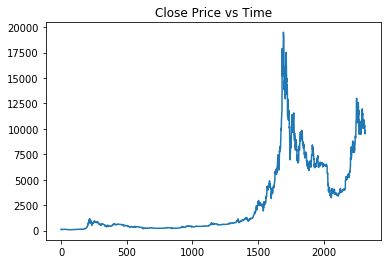

In [4]:
plt.plot(range(len(data['Close**'])), data['Close**'])
plt.title('Close Price vs Time')
plt.show()

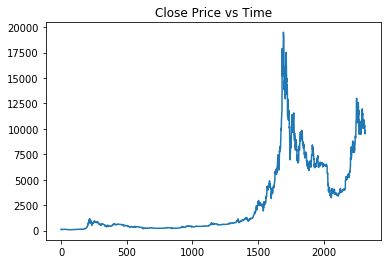

In [5]:
plt.plot(range(len(data['Close**'])), data['Close**'])
plt.title('Close Price vs Time')
plt.show()

In [6]:
# Normalize close price
from sklearn.preprocessing import MinMaxScaler
values = data['Close**'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(values)
scaled_price

array([[0.00338567],
       [0.00391735],
       [0.0036322 ],
       ...,
       [0.49049124],
       [0.4921635 ],
       [0.4987161 ]], dtype=float32)

In [7]:
# split data for training, testing
train_size = int(len(scaled_price) * 0.7)
test_size = len(scaled_price) - train_size

train, test = scaled_price[0:train_size,:], scaled_price[train_size:len(scaled_price),:]
print(len(train), len(test))

1622 696


In [8]:
def create_input(data,lookback):
    inputs = []
    for i in range(len(data) - lookback):
        temp_set = data[i:(i + lookback),0].copy()
        inputs.append(temp_set)
    return np.array(inputs)

def create_output(data,lookback):
    output = []
    for i in range(len(data)-lookback):
        output.append(data[i + lookback, 0])
    return np.array(output)

# use lookback = 5
x_train = create_input(train,5)
x_test = create_input(test,5)

y_train = create_output(train,5)
y_test = create_output(test,5)

print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)


x_train shape (1617, 5)
x_test shape (691, 5)
y_train shape (1617,)
y_test shape (691,)


In [9]:
x_train

array([[0.00338567, 0.00391735, 0.0036322 , 0.00249936, 0.00189305],
       [0.00391735, 0.0036322 , 0.00249936, 0.00189305, 0.00150909],
       [0.0036322 , 0.00249936, 0.00189305, 0.00150909, 0.00226826],
       ...,
       [0.21134934, 0.2107492 , 0.21978931, 0.2231364 , 0.22342357],
       [0.2107492 , 0.21978931, 0.2231364 , 0.22342357, 0.21869662],
       [0.21978931, 0.2231364 , 0.22342357, 0.21869662, 0.21416111]],
      dtype=float32)

In [10]:
y_train

array([0.00150909, 0.00226826, 0.00244377, ..., 0.21869662, 0.21416111,
       0.21925919], dtype=float32)

In [11]:
print("x_input:",x_train[0:4])
print("y:",y_train[0:3])

x_input: [[0.00338567 0.00391735 0.0036322  0.00249936 0.00189305]
 [0.00391735 0.0036322  0.00249936 0.00189305 0.00150909]
 [0.0036322  0.00249936 0.00189305 0.00150909 0.00226826]
 [0.00249936 0.00189305 0.00150909 0.00226826 0.00244377]]
y: [0.00150909 0.00226826 0.00244377]


In [12]:
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
print('x_train shape', x_train.shape)
print('x_test shape', x_test.shape)

x_train shape (1617, 1, 5)
x_test shape (691, 1, 5)


# Build Model

In [13]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, Flatten,Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import keras

model_1 = Sequential()
model_1.add(LSTM(100, input_shape=(1,x_train.shape[2])))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam')
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model_1.fit(x_train, y_train, epochs=100, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 1617 samples, validate on 691 samples
Epoch 1/100
1617/1617 [==============================] - 1s 612us/step - loss: 0.0228 - val_loss: 0.3423
Epoch 2/100
1617/1617 [==============================] - 0s 34us/step - loss: 0.0222 - val_loss: 0.3064
Epoch 3/100
1617/1617 [==============================] - 0s 34us/step - loss: 0.0193 - val_loss: 0.2720
Epoch 4/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0161 - val_loss: 0.2286
Epoch 5/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0140 - val_loss: 0.1860
Epoch 6/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0110 - val_loss: 0.1369
Epoch 7/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0084 - val_loss: 0.0843
Epoch 8/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0053 - val_loss: 0.0328
Epoch 9/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 0.0322
Epoch 10/100
161

1617/1617 [==============================] - 0s 31us/step - loss: 0.0017 - val_loss: 0.0183
Epoch 79/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0018 - val_loss: 0.0203
Epoch 80/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0021 - val_loss: 0.0231
Epoch 81/100
1617/1617 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0183
Epoch 82/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0022 - val_loss: 0.0190
Epoch 83/100
1617/1617 [==============================] - 0s 27us/step - loss: 0.0016 - val_loss: 0.0188
Epoch 84/100
1617/1617 [==============================] - 0s 27us/step - loss: 0.0024 - val_loss: 0.0192
Epoch 85/100
1617/1617 [==============================] - 0s 28us/step - loss: 0.0017 - val_loss: 0.0184
Epoch 86/100
1617/1617 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0198
Epoch 87/100
1617/1617 [==============================] - 0s 28us/st

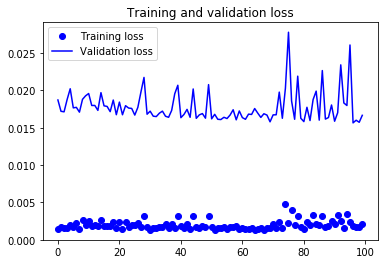

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

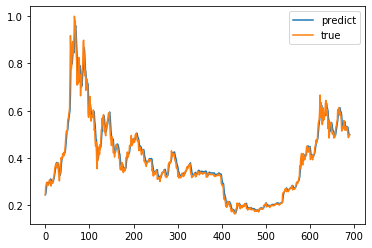

In [18]:
yhat = model_1.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [19]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 522.289


### Add a dropout layer

In [20]:
from keras import backend as K
K.clear_session()

In [21]:
model_2 = Sequential()
model_2.add(LSTM(100, input_shape=(1, x_train.shape[2])))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))
model_2.compile(loss='mae', optimizer='adam')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_2.compile(loss='mae', optimizer='adam')
history = model_2.fit(x_train, y_train, epochs=100, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1, shuffle=False)

Train on 1617 samples, validate on 691 samples
Epoch 1/100
1617/1617 [==============================] - 1s 558us/step - loss: 0.0195 - val_loss: 0.2814
Epoch 2/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0180 - val_loss: 0.2411
Epoch 3/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0145 - val_loss: 0.1945
Epoch 4/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0116 - val_loss: 0.1450
Epoch 5/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0088 - val_loss: 0.0919
Epoch 6/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0056 - val_loss: 0.0395
Epoch 7/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0264
Epoch 8/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0030 - val_loss: 0.0371
Epoch 9/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0026 - val_loss: 0.0272
Epoch 10/100
161

1617/1617 [==============================] - 0s 30us/step - loss: 0.0047 - val_loss: 0.0247
Epoch 79/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0030 - val_loss: 0.0309
Epoch 80/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0028 - val_loss: 0.0196
Epoch 81/100
1617/1617 [==============================] - 0s 30us/step - loss: 0.0028 - val_loss: 0.0254
Epoch 82/100
1617/1617 [==============================] - 0s 28us/step - loss: 0.0024 - val_loss: 0.0193
Epoch 83/100
1617/1617 [==============================] - 0s 29us/step - loss: 0.0023 - val_loss: 0.0204
Epoch 84/100
1617/1617 [==============================] - 0s 31us/step - loss: 0.0020 - val_loss: 0.0209
Epoch 85/100
1617/1617 [==============================] - 0s 28us/step - loss: 0.0020 - val_loss: 0.0210
Epoch 86/100
1617/1617 [==============================] - 0s 26us/step - loss: 0.0020 - val_loss: 0.0214
Epoch 87/100
1617/1617 [==============================] - 0s 27us/st

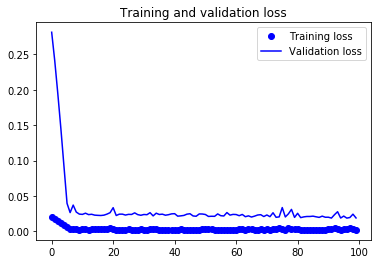

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

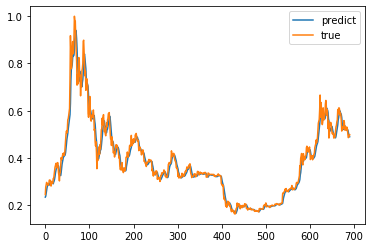

In [24]:
yhat = model_2.predict(x_test)
plt.plot(yhat, label='predict')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

In [25]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 595.991
